## Automatic type deduction

* Often the filter type can automatically be deduced from the input of the filter:

In [38]:
image = itk.imread("data/KitwareITK.jpg", itk.F)
# Filter types deduced from the image type.
median_filter = itk.MedianImageFilter.New(image, radius = 3)
median_filter.Update()
view(median_filter.GetOutput())

Vmlld2VyKGdyYWRpZW50X29wYWNpdHk9MC4yMiwgcmVuZGVyZWRfaW1hZ2U9PGl0a0ltYWdlUHl0aG9uLml0a0ltYWdlRjI7IHByb3h5IG9mIDxTd2lnIE9iamVjdCBvZiB0eXBlICdpdGtJbWHigKY=


* Note the absence of image type

### Type deduction exercises

* Using the previous `MeanImageFilter` exercise, use the type deduction method to instantiate filter.
* Using the previous `OtsuThresholdImageFilter` exercise, use the type deduction method to instantiate filter.
* What is the image type of the `OtsuThresholdImageFilter` output?

* Use the type deduction method to instantiate filter.

In [39]:
# mean_filter = itk. XX
# mean_filter.Update()
# mean_filtered_image = mean_filter.GetOutput()
# view(mean_filtered_image)

In [42]:
# %load solutions/4_Using_ITK_in_Python_real_world_filters_MeanFilter-TypeDeduction.py

* Using the previous `OtsuThresholdImageFilter` exercise, use the type deduction method to instantiate filter.
* What is the image type of the `OtsuThresholdImageFilter` output?

In [43]:
# otsu_filter = itk.XX
# otsu_filter.XX
# otsu_filtered_image = XX
# print(otsu_filtered_image)

In [46]:
# %load solutions/4_Using_ITK_in_Python_real_world_filters_OtsuFilter-TypeDeduction.py

## Simplify your code (and your life)

### Objects accessible by index (non exhaustive)
* MetaDataDictionary
* Index
* Point
* Vector
* Size

In [47]:
# Create an `Index` of dimension 3
index = itk.Index[3]()
index[0]=1
print("index value at position 0: %d"%index[0])

index value at position 0: 1


* Matrix is not, but you can get values with `()`

In [48]:
# Create a 3x3 `Matrix` of type float
m = itk.Matrix[itk.F,3,3]()
print("Value at coordinate 0,0: %f" % m(0,0))

Value at coordinate 0,0: 0.000000


* `itk.VariableLengthVector[itk.D]()` is neither.
* Need to set and get values using the `SetElement` and `GetElement` methods.

In [49]:
# Create a `VariableLengthVector of type `double` and initialize size to `1`
v = itk.VariableLengthVector[itk.D](1)
v.SetElement(0,1)
print("Value at coordinate 0,0: %f" % v.GetElement(0))

Value at coordinate 0,0: 1.000000


### Use Python objects instead of ITK objects

* Some filters expect inputs of a certain type

In [50]:
image = ImageType.New()
help(image.SetOrigin)

Help on method itkImageBase2_SetOrigin in module _itkImagePython:

itkImageBase2_SetOrigin(...) method of itkImagePython.itkImageF2 instance
    SetOrigin(itkPointD2 _arg)
    SetOrigin(double const * origin)
    itkImageBase2_SetOrigin(itkImageBase2 self, float const * origin)
    
    Set the origin of the
    image. The origin is the geometric coordinates of the image origin
    (pixel [0,0]). It is stored internally as SpacePrecisionType but may
    be set from float or double. See:   GetOrigin()



* Use Python `list` instead (for `Index`, `Point`, `Vector`)

In [51]:
image.SetOrigin([2,10])
print("Image origin: %s" % str(image.GetOrigin()))

Image origin: itkPointD2 ([2, 10])


## Appendix

### Functions to know
* `itk.imread(file_name [, pixel_type])`
* `itk.imwrite(image, file_name [, compression])`
* `itk.array_from_image(image)` and `itk.array_view_from_image(image)`
* `itk.image_from_array(arr)` and `itk.image_view_from_array(arr)`

### Pixel types - Two options
* itk.ctype('float'), itk.ctype('unsigned char')
* itk.F, itk.UC

### Convenience functions
* `itk.size(image)`
* `itk.spacing(image)`
* `itk.origin(image)`
* `itk.index(image)`
* `itk.physical_size(image)`

## Fixing errors

### Unsupported (image) types
* typical error message:

KeyError: "itkTemplate : No template [<class 'itkImagePython.itkImageD2'>] for the itk::ImageFileReader class"

In [53]:
# image = itk.imread("data/BrainProtonDensitySlice.png", itk.D)
# print(image)

* Select different input image type:

In [54]:
image = itk.imread("data/KitwareITK.jpg", itk.F)

* Cast to a different image type:

In [55]:
InputImageType = itk.Image[itk.F, 2]
OutputImageType = itk.Image[itk.UC, 2]
cast_filter = itk.CastImageFilter[InputImageType, OutputImageType].New(image)
cast_filter.Update()

* Converting a NumPy array with too many components along one dimension:
 * Use `itk.VectorImage`
 * Save it using `itk.imwrite()`

## Create your own pipeline

* Why?
 * Create a pipeline in a Python function.
 * Return the last filter output without updating it.
 * Error: Not be able to run the pipeline outside of the function.

* This does not work:

In [56]:
  def generateSource():
    reader = itk.ImageReader[ImageType].New()
    ...
    itkToVtkFilter = itk.ImageToVTKImageFilter[ImageType].New()
    itkToVtkFilter.SetInput(reader.GetOutput())
    return itkToVtkFilter.GetImporter()
 
  def main():
    source = generateSource()
    source.Update()

SyntaxError: invalid syntax (<ipython-input-56-60e88659c137>, line 3)

* Instead, you can create a pipeline, and use it where convenient:

In [57]:
def my_func(ImageType):
    my_pipeline = itk.pipeline()
    mean_filter = itk.MeanImageFilter[ImageType, ImageType].New()
    my_pipeline.connect(mean_filter)
    my_pipeline.expose("Radius")
    threshold_filter = itk.ThresholdImageFilter[ImageType].New()
    my_pipeline.connect(threshold_filter)
    my_pipeline.expose("Lower")
    return my_pipeline

PixelType = itk.UC
ImageType = itk.Image[PixelType, 2]
image = itk.imread("data/CBCT-TextureInput.png", PixelType)

my_pipeline = my_func(ImageType)
my_pipeline.SetInput(image)
my_pipeline.SetRadius(5)
my_pipeline.SetLower(100)
my_pipeline.Update()

view(my_pipeline.GetOutput())

Vmlld2VyKGdyYWRpZW50X29wYWNpdHk9MC4yMiwgcmVuZGVyZWRfaW1hZ2U9PGl0a0ltYWdlUHl0aG9uLml0a0ltYWdlVUMyOyBwcm94eSBvZiA8U3dpZyBPYmplY3Qgb2YgdHlwZSAnaXRrSW3igKY=


## Very Advanced topic

* disable lazy loading:

In [58]:
itk.force_load()

KeyError: 'absolute_value_difference_image_filter'

* call_back while importing ITK

In [ ]:
import itk
itk.auto_progress(True)
itk.force_load()
itk.auto_progress(False)

* Cast and downcast ITK objects

In [ ]:
ImageType = itk.Image[itk.F, 2]
filter = itk.MedianImageFilter[ImageType, ImageType].New()
casted_filter = itk.ProcessObject.cast(filter)
itk.down_cast(casted_filter)

## Views vs copy

So far we have used `itk.array_view_from_image()` and `itk.image_view_from_array()`. You can see the keyword `view` in both the names of these functions.

Let's compare the result of `itk.array_view_from_image()` and `itk.array_from_image()`

Text(0.5, 1.0, 'Copy')

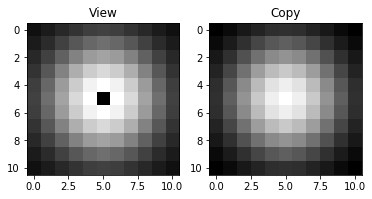

In [21]:
gaussian = itk.gaussian_image_source(Size=11, Sigma=3, Scale=100, Mean=[5,5])

arr_view_gaussian = itk.array_view_from_image(gaussian)
arr_gaussian = itk.array_from_image(gaussian)

gaussian.SetPixel([5,5],0)

plt.subplot(1, 2, 1)
plt.imshow(arr_view_gaussian)
plt.title("View")

plt.subplot(1, 2, 2)
plt.imshow(arr_gaussian)
plt.title("Copy")

### Exercise 2: ITK image to NumPy array

* Read an image with ITK
* Convert image to NumPy array
* Modify a pixel in the image
* Has the array been modified?
* Why did you make that choice?

In [22]:
# %load solutions/4_ITK_and_NumPy_answers_Exercise2.py